<a href="https://colab.research.google.com/github/DiNOV-Tokyo/yolov5/blob/main/DL_torchvsion_DCGAN_car_ex2_CarSelect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 現場で使える！　PyTorchPyTorch開発入門


##翔泳社

## 1.1 Google Drive をマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/Colab\ Notebooks
#%mkdir yolo_train
%cd yolo_train

/content/drive/My Drive/Colab Notebooks
/content/drive/My Drive/Colab Notebooks/yolo_train


## 1.2 モジュール読み込み

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
import time

import numpy as np
from tqdm import tqdm
from PIL import Image
import os
import copy

#from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
from torchvision.utils import save_image

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

# GPU/CPUが使えるかどうか確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

PyTorch Version:  1.9.0+cu102
Torchvision Version:  0.10.0+cu102
Setup complete. Using torch 1.9.0+cu102 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


device(type='cuda', index=0)

##DCGANによる画像生成

Stanfrod Cars Dataset

In [ ]:
# http://ai.stanford.edu/~jkrause/cars/car_dataset.html
#!wget http://ai.stanford.edu/~jkrause/car196/cars_train.tgz
#!tar xf cars_train.tgz
#!mkdir stanford-car
#!mkdir stanford-car/jpg
#!mv cars_train/*.jpg stanford-car/jpg

In [15]:
with open('./stanford-car/train_perfect_preds.txt', 'r') as f:
    car_list = f.read().split("\n")
    print(car_list)
    

['14', '3', '91', '134', '106', '123', '89', '96', '167', '58', '49', '186', '135', '85', '193', '172', '14', '73', '192', '57', '79', '36', '120', '170', '194', '134', '184', '86', '180', '194', '154', '139', '66', '133', '154', '104', '38', '97', '105', '142', '13', '191', '119', '38', '186', '25', '194', '177', '173', '42', '91', '148', '15', '97', '42', '53', '44', '65', '90', '124', '114', '190', '101', '187', '8', '17', '111', '122', '5', '29', '126', '94', '106', '106', '188', '59', '110', '43', '133', '111', '8', '192', '18', '116', '49', '145', '49', '170', '20', '114', '165', '138', '175', '112', '122', '104', '57', '51', '37', '71', '193', '105', '61', '74', '133', '162', '131', '88', '121', '180', '180', '137', '133', '71', '83', '110', '42', '177', '147', '161', '109', '28', '144', '53', '29', '66', '79', '13', '136', '143', '171', '89', '135', '161', '58', '122', '178', '56', '184', '191', '40', '60', '155', '71', '140', '42', '76', '187', '86', '8', '5', '47', '30', '18'

[1, 2, 11, 17, 18, 21, 33, 41, 46, 50, 55, 57, 65, 66, 69, 70, 76, 78, 81, 85, 87, 89, 98, 103, 117, 122, 125, 126, 127, 128, 146, 150, 151, 152, 159, 160, 161, 171, 176, 198, 200, 205, 206, 208, 209, 212, 215, 221, 227, 236, 238, 239, 244, 245, 255, 258, 261, 266, 274, 279, 282, 292, 302, 308, 312, 313, 318, 319, 320, 334, 340, 341, 346, 351, 358, 368, 370, 374, 384, 387, 392, 397, 399, 402, 405, 407, 408, 410, 411, 413, 419, 424, 425, 429, 436, 438, 439, 444, 446, 454, 456, 467, 490, 492, 503, 517, 520, 529, 532, 540, 546, 547, 548, 549, 551, 562, 564, 566, 579, 581, 592, 593, 598, 600, 601, 602, 603, 607, 611, 612, 631, 632, 634, 635, 638, 642, 647, 653, 654, 660, 661, 664, 668, 670, 676, 681, 684, 689, 691, 697, 698, 700, 720, 723, 724, 725, 728, 733, 740, 742, 745, 749, 750, 758, 759, 767, 769, 770, 772, 783, 785, 792, 793, 795, 803, 820, 825, 829, 831, 835, 858, 865, 870, 878, 880, 886, 888, 896, 897, 898, 899, 905, 912, 918, 920, 923, 924, 925, 926, 929, 930, 932, 934, 938, 948,

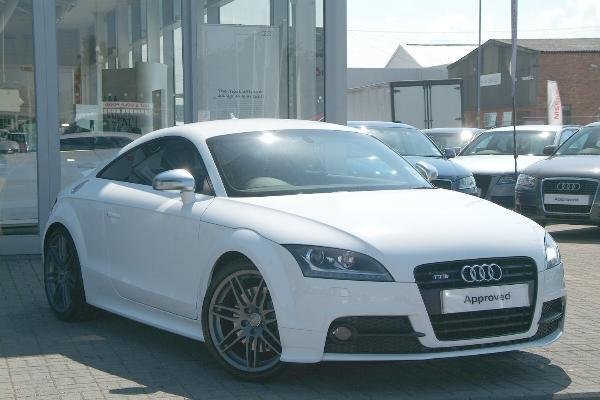

In [187]:
#print(car_list)
#selected_list = [i for i in car_list if i in ['14', '321']]
#print(selected_list)
# 特定の車種を選択する
# 普通のセダン系。スポーツカー、クラシック、トラック, SUV　とかは除く <= 目視で選別
selected_car = ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '13', '14', '16', '17', '19', '20', '22', '23', '24', '25', '26', '28', '29', '33', '34', '35', '42', '43', '44', 
               '47', '49', '51', '59', '61', '63', '66', '67', '72', '73', '79', '80']
#selected_car = ['80']
cnt = 0
select_list = []
for i in car_list:
  cnt += 1
  if i in selected_car:
    select_list.append(cnt)
  
print(select_list)
print(len(selected_car))
print(len(select_list))
#print('{:0>5}'.format(select_list[0]))
display_jpeg(Image('stanford-car/jpg/' + '{:0>5}'.format(select_list[0]) +'.jpg'))

In [184]:
# 選択した車種をコピーするフォルダの作成
!mkdir stanford-car_selected
!mkdir stanford-car_selected/jpg

In [188]:
# 選択した車種の画像データをコピー
import shutil

for k in select_list:
  file_name = '{:0>5}'.format(k) +'.jpg'
  src = 'stanford-car/jpg/' + file_name
  copy = 'stanford-car_selected/jpg/' + file_name
  shutil.copyfile(src, copy)

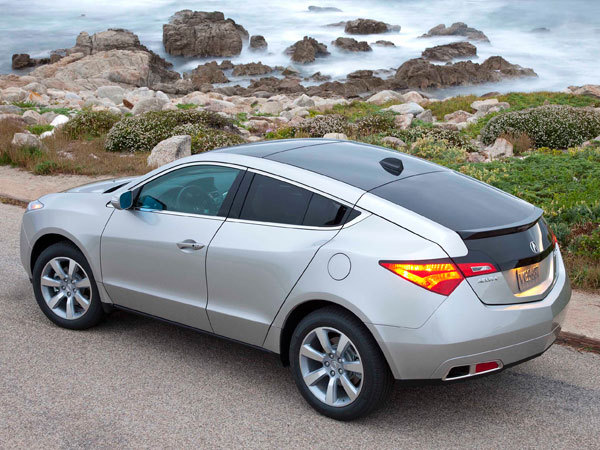

In [82]:
from IPython.display import Image,display_jpeg
#display_jpeg(Image('cars_train/080.jpg'))
display_jpeg(Image('stanford-car/jpg/00236.jpg'))

In [14]:
label_map = {100: 100}
[(img, label_map[label])
    for img, label in img_loader if label in [100]]
  #print(label)


RuntimeError: ignored

In [194]:
#img_data = ImageFolder("./stanford-car",
img_data = ImageFolder("./stanford-car_selected",
    transform=transforms.Compose([
        transforms.Resize(160),
        transforms.CenterCrop(128),
        transforms.ToTensor()
]))

#batch_size = 8
batch_size = 64
img_loader = DataLoader(img_data, batch_size=batch_size,
                        shuffle=True)

In [ ]:
#print(img_loader)
for real_img, dat in img_loader:
      batch_len = len(real_img)
      print(real_img[8])
      print(batch_len)
      #print(real_img.size())

IndexError: ignored

データの確認

In [ ]:
batch_iterator = iter(img_loader)
imges = next(batch_iterator)
print(imges[0].size())

torch.Size([8, 3, 128, 128])


画像生成モデル

In [197]:
nz = 100
ngf = 32

class GNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8,   
                               4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 8, ngf * 8, 
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 2, ngf,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf, 3,
                               4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        out = self.main(x)
        return out

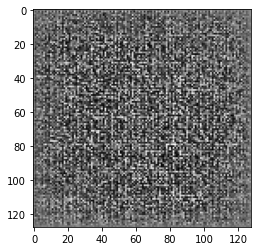

In [177]:
# 動作確認
import matplotlib.pyplot as plt
%matplotlib inline

G = GNet()

# 入力する乱数
input_z = torch.randn(1, 100)

# テンソルサイズを(1, 100, 1, 1)に変形
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# 偽画像を出力
fake_images = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

In [ ]:
fake_images.size()

torch.Size([1, 3, 128, 128])

識別モデル

In [198]:
ndf = 128
ndf = 32

class DNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 2, 0, bias=False),
        )

    def forward(self, x):
        out = self.main(x)
        return out.squeeze()

In [ ]:
# 動作確認
D = DNet()
#D = Discriminator(z_dim=20, image_size=64)

# 偽画像を生成
input_z = torch.randn(1, 100)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)
print(fake_images.size())
# 偽画像をDに入力
d_out = D(fake_images)
print(d_out.size())
# 出力d_outにSigmoidをかけて0から1に変換
#print(nn.Sigmoid()(d_out))

torch.Size([1, 3, 128, 128])
torch.Size([])


訓練関数の作成

In [199]:
d = DNet().to("cuda:0")
g = GNet().to("cuda:0")

# Adamのパラメータは元論文の提案値
opt_d = optim.Adam(d.parameters(),
    lr=0.0002, betas=(0.5, 0.999))
opt_g = optim.Adam(g.parameters(),
    lr=0.0002, betas=(0.5, 0.999))

# クロスエントロピーを計算するための補助変数など
ones = torch.ones(batch_size).to("cuda:0")
zeros = torch.zeros(batch_size).to("cuda:0")
loss_f = nn.BCEWithLogitsLoss()

# モニタリング用のz
fixed_z = torch.randn(batch_size, nz, 1, 1).to("cuda:0")

In [ ]:
for real_img, _ in img_loader:
    print(real_img.size())
    real_out = d(real_img)
    print("Here")

torch.Size([8, 3, 128, 128])


RuntimeError: ignored

In [200]:
from statistics import mean

def train_dcgan(g, d, opt_g, opt_d, loader):
    # 生成モデル、識別モデルの目的関数の追跡用の配列
    log_loss_g = []
    log_loss_d = []
#    for real_img, _ in loader:
    for real_img, _ in tqdm(loader):
        batch_len = len(real_img)
        
         # 実際の画像をGPUにコピー
        real_img = real_img.to("cuda:0")
        
         # 偽画像を乱数と生成モデルから作る
        z = torch.randn(batch_len, nz, 1, 1).to("cuda:0")
        fake_img = g(z)
        
        # 後で使用するので偽画像の値のみ取り出しておく
        fake_img_tensor = fake_img.detach()
        # 偽画像に対する生成モデルの評価関数を計算する
        out = d(fake_img)

        loss_g = loss_f(out, ones[: batch_len])
        log_loss_g.append(loss_g.item())
        
        # 計算グラフが生成モデルと識別モデルの両方に
        # 依存しているので両者とも勾配をクリアしてから
        # 微分の計算とパラメータ更新を行う
        d.zero_grad(), g.zero_grad()
        loss_g.backward()
        opt_g.step()

        # 実際の画像に対する識別モデルの評価関数を計算
        real_out = d(real_img)

        loss_d_real = loss_f(real_out, ones[: batch_len])
        
        # PyTorchでは同じTensorを含んだ計算グラフに対して
        # 2回backwardを行うことができないので保存してあった
        # Tensorを使用して無駄な計算を省く
        fake_img = fake_img_tensor
        
        # 偽画像に対する識別モデルの評価関数の計算
        fake_out = d(fake_img_tensor)
        loss_d_fake = loss_f(fake_out, zeros[: batch_len])
        
        # 実偽の評価関数の合計値
        loss_d = loss_d_real + loss_d_fake
        log_loss_d.append(loss_d.item())
        
        # 識別モデルの微分計算とパラメータ更新
        d.zero_grad(), g.zero_grad()
        loss_d.backward()
        opt_d.step()

    return mean(log_loss_g), mean(log_loss_d)

訓練開始

In [ ]:

import datetime

for epoch in range(300):
    train_dcgan(g, d, opt_g, opt_d, img_loader)
    print("{} Epoch {}: ".format(datetime.datetime.now(), epoch))
    # 10回の繰り返しごとに学習結果を保存する
    if epoch % 10 == 0:
        # パラメータの保存
        #torch.save(
        #    g.state_dict(),
         #   "cars_train/g_{:03d}.prm".format(epoch),
          #  pickle_protocol=4)
        #torch.save(
         #   d.state_dict(),
          #  "cars_train/d_{:03d}.prm".format(epoch),
           # pickle_protocol=4)
        # モニタリング用のzから生成した画像を保存
        generated_img = g(fixed_z)
        save_image(generated_img,
                   "./stanford-car_selected/b64-{:03d}.jpg".format(epoch))

100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


2021-09-25 12:28:36.937964 Epoch 0: 


100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


2021-09-25 12:29:05.214093 Epoch 1: 


100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


2021-09-25 12:29:33.415652 Epoch 2: 


100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


2021-09-25 12:30:01.626497 Epoch 3: 


100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


2021-09-25 12:30:29.768756 Epoch 4: 


100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


2021-09-25 12:30:58.113171 Epoch 5: 


100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


2021-09-25 12:31:26.314220 Epoch 6: 


100%|██████████| 27/27 [00:27<00:00,  1.03s/it]


2021-09-25 12:31:54.227843 Epoch 7: 


100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


2021-09-25 12:32:20.743895 Epoch 8: 


100%|██████████| 27/27 [00:26<00:00,  1.00it/s]


2021-09-25 12:32:47.723667 Epoch 9: 


100%|██████████| 27/27 [00:27<00:00,  1.00s/it]


2021-09-25 12:33:14.787189 Epoch 10: 


100%|██████████| 27/27 [00:26<00:00,  1.00it/s]


2021-09-25 12:33:41.920226 Epoch 11: 


100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


2021-09-25 12:34:08.711701 Epoch 12: 


100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


2021-09-25 12:34:34.877145 Epoch 13: 


100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


2021-09-25 12:35:01.287954 Epoch 14: 


100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


2021-09-25 12:35:27.832414 Epoch 15: 


100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


2021-09-25 12:35:54.595387 Epoch 16: 


100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


2021-09-25 12:36:21.361809 Epoch 17: 


100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


2021-09-25 12:36:48.095640 Epoch 18: 


100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


2021-09-25 12:37:14.826288 Epoch 19: 


100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


2021-09-25 12:37:41.696970 Epoch 20: 


100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


2021-09-25 12:38:08.718315 Epoch 21: 


100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


2021-09-25 12:38:35.414327 Epoch 22: 


100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


2021-09-25 12:39:02.181984 Epoch 23: 


100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


2021-09-25 12:39:28.914299 Epoch 24: 


100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


2021-09-25 12:39:55.600264 Epoch 25: 


100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


2021-09-25 12:40:22.150864 Epoch 26: 


100%|██████████| 27/27 [00:25<00:00,  1.05it/s]


2021-09-25 12:40:47.978972 Epoch 27: 


100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


2021-09-25 12:41:14.193302 Epoch 28: 


100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


2021-09-25 12:41:40.901717 Epoch 29: 


100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


2021-09-25 12:42:07.527498 Epoch 30: 


100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


2021-09-25 12:42:34.550938 Epoch 31: 


100%|██████████| 27/27 [00:27<00:00,  1.00s/it]


2021-09-25 12:43:01.600140 Epoch 32: 


100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


2021-09-25 12:43:28.241356 Epoch 33: 


100%|██████████| 27/27 [00:26<00:00,  1.04it/s]


2021-09-25 12:43:54.259870 Epoch 34: 


100%|██████████| 27/27 [00:26<00:00,  1.04it/s]


2021-09-25 12:44:20.356403 Epoch 35: 


100%|██████████| 27/27 [00:25<00:00,  1.04it/s]


2021-09-25 12:44:46.326081 Epoch 36: 


100%|██████████| 27/27 [00:26<00:00,  1.04it/s]


2021-09-25 12:45:12.406590 Epoch 37: 


100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


2021-09-25 12:45:38.513113 Epoch 38: 


100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


2021-09-25 12:46:04.695638 Epoch 39: 


100%|██████████| 27/27 [00:25<00:00,  1.04it/s]


2021-09-25 12:46:30.661958 Epoch 40: 


100%|██████████| 27/27 [00:25<00:00,  1.04it/s]


2021-09-25 12:46:56.754384 Epoch 41: 


100%|██████████| 27/27 [00:25<00:00,  1.05it/s]


2021-09-25 12:47:22.358223 Epoch 42: 


100%|██████████| 27/27 [00:25<00:00,  1.04it/s]


2021-09-25 12:47:48.305110 Epoch 43: 


100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


2021-09-25 12:48:14.475085 Epoch 44: 


100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


2021-09-25 12:48:40.665155 Epoch 45: 


100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


2021-09-25 12:49:07.011863 Epoch 46: 


100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


2021-09-25 12:49:33.167032 Epoch 47: 


100%|██████████| 27/27 [00:25<00:00,  1.04it/s]


2021-09-25 12:49:59.179465 Epoch 48: 


100%|██████████| 27/27 [00:25<00:00,  1.04it/s]


2021-09-25 12:50:25.124572 Epoch 49: 


100%|██████████| 27/27 [00:25<00:00,  1.04it/s]


2021-09-25 12:50:51.026032 Epoch 50: 


100%|██████████| 27/27 [00:25<00:00,  1.05it/s]


2021-09-25 12:51:16.987544 Epoch 51: 


100%|██████████| 27/27 [00:25<00:00,  1.05it/s]


2021-09-25 12:51:42.668560 Epoch 52: 


100%|██████████| 27/27 [00:25<00:00,  1.04it/s]


2021-09-25 12:52:08.619404 Epoch 53: 


100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


2021-09-25 12:52:35.041507 Epoch 54: 


100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


2021-09-25 12:53:01.580587 Epoch 55: 


100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


2021-09-25 12:53:28.195979 Epoch 56: 


100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


2021-09-25 12:53:54.355989 Epoch 57: 


100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


2021-09-25 12:54:20.729018 Epoch 58: 


100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


2021-09-25 12:54:47.392735 Epoch 59: 


100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


2021-09-25 12:55:14.077785 Epoch 60: 


100%|██████████| 27/27 [00:27<00:00,  1.00s/it]


2021-09-25 12:55:41.281894 Epoch 61: 


100%|██████████| 27/27 [00:27<00:00,  1.01s/it]


2021-09-25 12:56:08.485320 Epoch 62: 


100%|██████████| 27/27 [00:27<00:00,  1.01s/it]


2021-09-25 12:56:35.647925 Epoch 63: 


100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


2021-09-25 12:57:02.044220 Epoch 64: 


100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


2021-09-25 12:57:28.424051 Epoch 65: 


100%|██████████| 27/27 [00:25<00:00,  1.04it/s]


2021-09-25 12:57:54.381370 Epoch 66: 


100%|██████████| 27/27 [00:25<00:00,  1.04it/s]


2021-09-25 12:58:20.322105 Epoch 67: 


100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


2021-09-25 12:58:46.509531 Epoch 68: 


100%|██████████| 27/27 [00:26<00:00,  1.04it/s]


2021-09-25 12:59:12.549262 Epoch 69: 


100%|██████████| 27/27 [00:25<00:00,  1.05it/s]


2021-09-25 12:59:38.261208 Epoch 70: 


100%|██████████| 27/27 [00:25<00:00,  1.05it/s]


2021-09-25 13:00:04.108430 Epoch 71: 


100%|██████████| 27/27 [00:25<00:00,  1.05it/s]


2021-09-25 13:00:29.769608 Epoch 72: 


100%|██████████| 27/27 [00:25<00:00,  1.05it/s]


2021-09-25 13:00:55.532890 Epoch 73: 


100%|██████████| 27/27 [00:25<00:00,  1.05it/s]


2021-09-25 13:01:21.237622 Epoch 74: 


100%|██████████| 27/27 [00:25<00:00,  1.05it/s]


2021-09-25 13:01:46.914911 Epoch 75: 


100%|██████████| 27/27 [00:25<00:00,  1.05it/s]


2021-09-25 13:02:12.760434 Epoch 76: 


100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


2021-09-25 13:02:39.127134 Epoch 77: 


100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


2021-09-25 13:03:05.896580 Epoch 78: 


100%|██████████| 27/27 [00:27<00:00,  1.01s/it]


2021-09-25 13:03:33.153280 Epoch 79: 


100%|██████████| 27/27 [00:27<00:00,  1.00s/it]


2021-09-25 13:04:00.223661 Epoch 80: 


100%|██████████| 27/27 [00:27<00:00,  1.00s/it]


2021-09-25 13:04:27.438736 Epoch 81: 


100%|██████████| 27/27 [00:27<00:00,  1.00s/it]


2021-09-25 13:04:54.501198 Epoch 82: 


100%|██████████| 27/27 [00:27<00:00,  1.00s/it]


2021-09-25 13:05:21.610773 Epoch 83: 


100%|██████████| 27/27 [00:27<00:00,  1.00s/it]


2021-09-25 13:05:48.747679 Epoch 84: 


100%|██████████| 27/27 [00:27<00:00,  1.01s/it]


2021-09-25 13:06:16.082105 Epoch 85: 


100%|██████████| 27/27 [00:27<00:00,  1.01s/it]


2021-09-25 13:06:43.251378 Epoch 86: 


100%|██████████| 27/27 [00:27<00:00,  1.01s/it]


2021-09-25 13:07:10.497528 Epoch 87: 


100%|██████████| 27/27 [00:27<00:00,  1.01s/it]


2021-09-25 13:07:37.706344 Epoch 88: 


100%|██████████| 27/27 [00:27<00:00,  1.01s/it]


2021-09-25 13:08:04.971958 Epoch 89: 


100%|██████████| 27/27 [00:27<00:00,  1.01s/it]


2021-09-25 13:08:32.360319 Epoch 90: 


100%|██████████| 27/27 [00:27<00:00,  1.02s/it]


2021-09-25 13:09:00.123859 Epoch 91: 


100%|██████████| 27/27 [00:27<00:00,  1.01s/it]


2021-09-25 13:09:27.369917 Epoch 92: 


100%|██████████| 27/27 [00:27<00:00,  1.02s/it]


2021-09-25 13:09:54.810401 Epoch 93: 


100%|██████████| 27/27 [00:27<00:00,  1.02s/it]


2021-09-25 13:10:22.455071 Epoch 94: 


100%|██████████| 27/27 [00:27<00:00,  1.02s/it]


2021-09-25 13:10:50.040679 Epoch 95: 


100%|██████████| 27/27 [00:27<00:00,  1.01s/it]


2021-09-25 13:11:17.213307 Epoch 96: 


100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


2021-09-25 13:11:44.068846 Epoch 97: 


100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


2021-09-25 13:12:10.579238 Epoch 98: 


100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


2021-09-25 13:12:37.253673 Epoch 99: 


100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


2021-09-25 13:13:03.748667 Epoch 100: 


100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


2021-09-25 13:13:30.530988 Epoch 101: 


100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


2021-09-25 13:13:57.271078 Epoch 102: 


100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


2021-09-25 13:14:23.785455 Epoch 103: 


100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


2021-09-25 13:14:50.122331 Epoch 104: 


100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


2021-09-25 13:15:16.800322 Epoch 105: 


100%|██████████| 27/27 [00:26<00:00,  1.00it/s]


2021-09-25 13:15:43.744667 Epoch 106: 


100%|██████████| 27/27 [00:27<00:00,  1.01s/it]


2021-09-25 13:16:11.062001 Epoch 107: 


100%|██████████| 27/27 [00:27<00:00,  1.01s/it]


2021-09-25 13:16:38.313881 Epoch 108: 


100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


2021-09-25 13:17:04.849346 Epoch 109: 


100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


2021-09-25 13:17:31.326282 Epoch 110: 


100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


2021-09-25 13:17:57.697209 Epoch 111: 


100%|██████████| 27/27 [00:26<00:00,  1.04it/s]


2021-09-25 13:18:23.742019 Epoch 112: 


100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


2021-09-25 13:18:49.990969 Epoch 113: 


100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


2021-09-25 13:19:16.486776 Epoch 114: 


100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


2021-09-25 13:19:42.971541 Epoch 115: 


100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


2021-09-25 13:20:09.528148 Epoch 116: 


100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


2021-09-25 13:20:35.758608 Epoch 117: 


100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


2021-09-25 13:21:01.916410 Epoch 118: 


100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


2021-09-25 13:21:28.231631 Epoch 119: 


100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


2021-09-25 13:21:54.524918 Epoch 120: 


100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


2021-09-25 13:22:21.000991 Epoch 121: 


100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


2021-09-25 13:22:47.238591 Epoch 122: 


100%|██████████| 27/27 [00:25<00:00,  1.04it/s]


2021-09-25 13:23:13.210311 Epoch 123: 


100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


2021-09-25 13:23:39.327115 Epoch 124: 


100%|██████████| 27/27 [00:25<00:00,  1.04it/s]


2021-09-25 13:24:05.258526 Epoch 125: 


100%|██████████| 27/27 [00:26<00:00,  1.04it/s]


2021-09-25 13:24:31.325346 Epoch 126: 


100%|██████████| 27/27 [00:25<00:00,  1.05it/s]


2021-09-25 13:24:57.143315 Epoch 127: 


100%|██████████| 27/27 [00:25<00:00,  1.05it/s]


2021-09-25 13:25:22.936972 Epoch 128: 


100%|██████████| 27/27 [00:26<00:00,  1.04it/s]


2021-09-25 13:25:49.028804 Epoch 129: 


100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


2021-09-25 13:26:15.861152 Epoch 130: 


100%|██████████| 27/27 [00:26<00:00,  1.00it/s]


2021-09-25 13:26:43.000171 Epoch 131: 


100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


2021-09-25 13:27:09.761854 Epoch 132: 


100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


2021-09-25 13:27:36.080783 Epoch 133: 


100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


2021-09-25 13:28:02.476887 Epoch 134: 


100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


2021-09-25 13:28:28.782981 Epoch 135: 


100%|██████████| 27/27 [00:25<00:00,  1.04it/s]


2021-09-25 13:28:54.760604 Epoch 136: 


100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


2021-09-25 13:29:21.054653 Epoch 137: 


100%|██████████| 27/27 [00:25<00:00,  1.04it/s]


2021-09-25 13:29:47.018679 Epoch 138: 


100%|██████████| 27/27 [00:26<00:00,  1.04it/s]


2021-09-25 13:30:13.112867 Epoch 139: 


100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


2021-09-25 13:30:39.358115 Epoch 140: 


100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


2021-09-25 13:31:05.916207 Epoch 141: 


100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


2021-09-25 13:31:32.494191 Epoch 142: 


100%|██████████| 27/27 [00:26<00:00,  1.00it/s]


2021-09-25 13:31:59.487203 Epoch 143: 


100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


2021-09-25 13:32:26.046514 Epoch 144: 


100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


2021-09-25 13:32:52.419879 Epoch 145: 


100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


2021-09-25 13:33:18.631253 Epoch 146: 


100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


2021-09-25 13:33:45.173912 Epoch 147: 


100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


2021-09-25 13:34:11.600533 Epoch 148: 


100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


2021-09-25 13:34:38.478253 Epoch 149: 


100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


2021-09-25 13:35:04.937000 Epoch 150: 


100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


2021-09-25 13:35:31.474853 Epoch 151: 


100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


2021-09-25 13:35:57.630785 Epoch 152: 


100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


2021-09-25 13:36:23.792639 Epoch 153: 


 22%|██▏       | 6/27 [00:06<00:21,  1.01s/it]

結果の表示

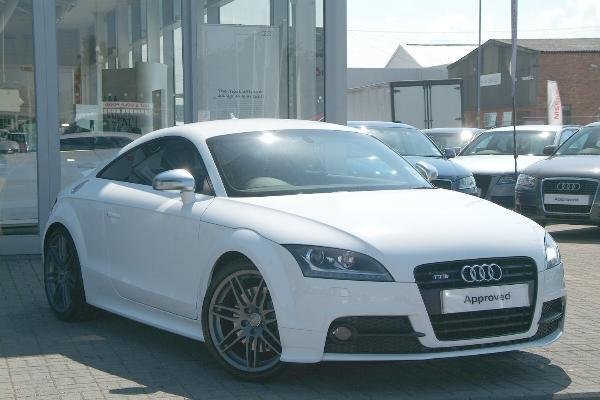

In [34]:
from IPython.display import Image,display_jpeg
#display_jpeg(Image('cars_train/080.jpg'))
display_jpeg(Image('stanford-car/jpg/00001.jpg'))

In [ ]:
!ls -all

total 337172
drwsrwsr-x 1 jovyan users      4096 Sep  4 21:50 .
drwxr-xr-x 1 root   root       4096 Sep  3 12:01 ..
-rw-r--r-- 1 jovyan users 344862509 Feb 20  2009 102flowers.tgz
-rw-rw-r-- 1 jovyan users       220 Feb 25  2020 .bash_logout
-rw-rw-r-- 1 jovyan users      3823 Sep  3 12:01 .bashrc
drwsrwsr-x 1 jovyan users      4096 Sep  5 00:01 .cache
drwsrwsr-x 1 jovyan users      4096 Sep  3 12:02 .conda
drwxr-sr-x 1 jovyan users      4096 Sep  4 01:04 FashionMNIST
drwxr-sr-x 1 jovyan users      4096 Sep  4 00:53 .ipynb_checkpoints
drwxr-sr-x 1 jovyan users      4096 Sep  4 00:53 .ipython
drwxr-sr-x 2 jovyan users    274432 Sep  4 21:50 jpg
drwsrws--- 1 jovyan users      4096 Sep  4 01:38 .jupyter
drwxr-sr-x 1 jovyan users      4096 Sep  4 00:53 .local
drwsrwsr-x 2 jovyan users      4096 Sep  3 12:02 .npm
drwx--S--- 3 jovyan users      4096 Sep  4 01:11 .nv
drwxr-sr-x 3 jovyan users      4096 Sep  4 23:47 oxford-102
-rw-rw-r-- 1 jovyan users       807 Feb 25  2020 .profile
-rw-r--r-